In [1]:
!pip install timm
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.4
    Uninstalling transformers-4.27.4:
      Successfully uninstalled transformers-4.27.4


In [2]:
!export CUDA_LAUNCH_BLOCKING=1

In [3]:
## import the libraries
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm, trange
import albumentations as A
import matplotlib.pyplot as plt
import pickle 
import time

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from transformers import BertLMHeadModel, BertTokenizer
from nltk.translate.bleu_score import corpus_bleu
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer

from collections import OrderedDict
from typing import Tuple, Union

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import hashlib
import os
import urllib
import urllib.request

import warnings
from typing import Any, Union, List
from pkg_resources import packaging

from PIL import Image
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [4]:
t = time.localtime()
print(t)
current_time = time.strftime("%H_%M_%S", t)
print(current_time)

time.struct_time(tm_year=2023, tm_mon=5, tm_mday=2, tm_hour=17, tm_min=37, tm_sec=42, tm_wday=1, tm_yday=122, tm_isdst=0)
17_37_42


In [5]:
# a little pre-processing
image_path = "/kaggle/input/flickr8k/Images/"
captions_path = "/kaggle/input/flickr8k"
df = pd.read_csv(captions_path + "/captions.txt")
i=0
for index, row in df.iterrows():
  i+=1
  path_file = f"{image_path}/{row['image']}"
  if not(os.path.exists(path_file)):
    df.drop(index, axis=0, inplace = True)
  if(i==25):
    break
df['id'] = df['id'] = [id_ for _ in range(int(df.shape[0]/5)) for id_ in range(5)] 
df.to_csv("/kaggle/working/captions.csv")
df = pd.read_csv("/kaggle/working//captions.csv")
print("total length of df is: ", len(df))
print("total number of images: ", len(df)/5)
print(df.head())


total length of df is:  40455
total number of images:  8091.0
   Unnamed: 0                      image  \
0           0  1000268201_693b08cb0e.jpg   
1           1  1000268201_693b08cb0e.jpg   
2           2  1000268201_693b08cb0e.jpg   
3           3  1000268201_693b08cb0e.jpg   
4           4  1000268201_693b08cb0e.jpg   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   1  
2   A little girl climbing into a wooden playhouse .   2  
3  A little girl climbing the stairs to her playh...   3  
4  A little girl in a pink dress going into a woo...   4  


# CONFIG
Config file is for basic configurations variables


In [6]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    data_path = "/content"
    batch_size = 2
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch_device

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "gpt2"
    text_embedding = 768
    text_tokenizer = "gpt2"
    max_length = 800

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    ## preprocess of dataset
    prefix_length = 10
    normalize_prefix = True
    prefix_size = 512

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

    #path to save model
   
    best_model_path = f"/kaggle/working/"

# Utils

In [7]:
print(torch_device)

cuda


In [8]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


# Dataset and Transformation

In [9]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, captions_raw, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.tokenizer = tokenizer
        self.transforms = transforms
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.prefix_length = CFG.prefix_length
        self.normalize_prefix = CFG.normalize_prefix
        
        # encode the captions with padding
        self.image_ids = [caption["image"] for idx, caption in captions_raw.iterrows()]
        self.captions = [caption['caption'] for idx, caption in captions_raw.iterrows()]
        
        self.captions_tokens = []
        self.max_seq_len = 50
        for idx, caption in captions_raw.iterrows():
            self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
        print("caption_tokens", len(self.captions_tokens))
        print("image ids ", len(self.image_ids), len(self.captions))
        
    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
#         print("maximum seq length", self.max_seq_len)
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask
    
    def __getitem__(self, idx):
        item = {}
        path_to_file = f"{CFG.image_path}/{self.image_ids[idx]}"
        # print(item)
        file_exists = os.path.exists(path_to_file)
        if file_exists:
#           print("path to file ", path_to_file)
          image = cv2.imread(path_to_file)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = self.transforms(image=image)['image']
          item['image'] = torch.tensor(image).permute(2, 0, 1).float()
          item['image'] = item['image']
          item['caption'] = self.captions[idx]
#         else:
#             print("no file found")
          # print("what is caption?", item['caption'])
        # return item
        tokens, mask = self.pad_tokens(idx)
        # prefix = self.prefixes[self.caption2embedding[item]]
        item['tokens'] = tokens
        item['mask'] = mask
        # if self.normalize_prefix:
        #     prefix = prefix.float()
        #     prefix = prefix / prefix.norm(2, -1)
        return item


    def __len__(self):
        return len(self.captions_tokens)



def get_transforms( size, mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(size, size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(size, size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

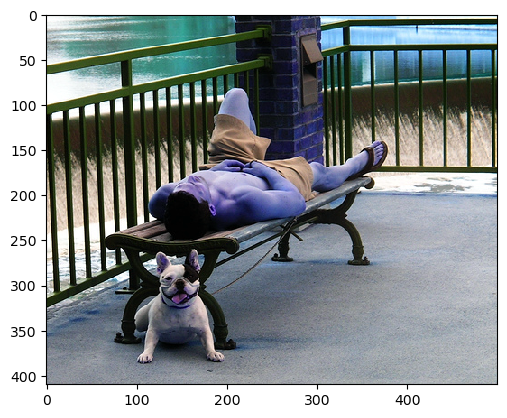

In [10]:
tran = get_transforms(288)
image_path = f"{CFG.image_path}/1003163366_44323f5815.jpg"
image = cv2.imread(image_path)
plt.imshow(image, interpolation='nearest')
plt.show()


dict_keys(['image'])


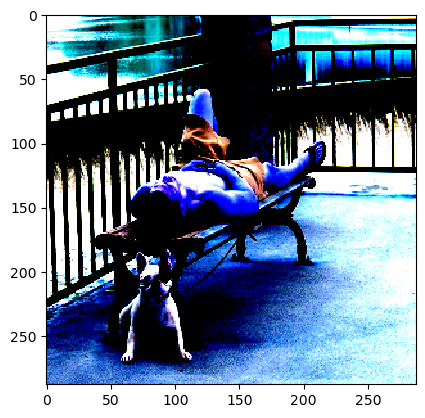

In [11]:
imagex = tran(image = image)
print(imagex.keys())
from matplotlib import pyplot as plt
plt.imshow(imagex['image'], interpolation='nearest')
plt.show()

# Image Encoder

In [12]:
## First is the BottleNeck layer for ResNet50 which is the basic block of residual network
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out



In [13]:
## Attention pool is to add an attention layer

class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        # print(spacial_dim)
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x_mean = x.mean(dim=0, keepdim=True)  # 1 x 1 x N x C
        # print("mean shape", x_mean.shape, x.shape)
        x = torch.cat([x_mean, x], dim=0)  # (HW+1)NC
        # print("inside attention pool2d forward function ", x.shape)
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)

In [14]:
## resnet class
class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        # print(embed_dim, input_resolution)
        # print("input to attnpool1 ", input_resolution//4, embed_dim/8, heads, output_dim//8)
        self.attnpool1 = AttentionPool2d(input_resolution // 4, embed_dim//8, heads, output_dim//8)
        self.attnpool2 = AttentionPool2d(input_resolution // 8, embed_dim//4, heads, output_dim//4)
        self.attnpool3 = AttentionPool2d(input_resolution // 16, embed_dim//2, heads, output_dim//2)
        self.attnpool4 = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)
        self.lin1 = nn.Linear(output_dim//8, output_dim)
        self.lin2 = nn.Linear(output_dim//4, output_dim)
        self.lin3 = nn.Linear(output_dim//2, output_dim)
        self.lin4 = nn.Linear(output_dim*15//8,output_dim)
        self.lin5 = nn.Linear(output_dim, 512)
        # print("inside modified resnet", width, input_resolution, layers)
    
    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x
        #x = x.cuda()
        x = x.type(self.conv1.weight.dtype)
        
        x = stem(x)
        x = self.layer1(x)
        x1 = self.attnpool1(x)
        # x1 = self.lin1(x1)
        # print("x1 shape ", x1.shape)
        x = self.layer2(x)
        x2 = self.attnpool2(x)
        # x2 = self.lin2(x2)
        # print("x2 shape ", x2.shape)
        x = self.layer3(x)
        x3 = self.attnpool3(x)
        # x3 = self.lin3(x3)
        # print("x3 shape ", x3.shape)
        # cat = 
        x = self.layer4(x)
        x4 = self.attnpool4(x)
        # print("x4 shape ", x4.shape)
        cat = torch.concat((x1, x2, x3, x4), 1)
        # print(cat.shape)
        x4 = self.lin4(cat)
        x = self.lin5(x4)

        return x


In [15]:
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


In [16]:
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


In [17]:
## CLIP image encoder uses ResNet or ViT

class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x




In [18]:
class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


In [19]:
# CLIP class
class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 criterion,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()
        self.criterion = criterion
        self.context_length = context_length
        self.vision_width = vision_width
        self.transformer_width = transformer_width
        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.model_name_or_path = "gpt2"
        self.gpt = GPT2LMHeadModel.from_pretrained(self.model_name_or_path)
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP((CFG.prefix_size, (self.gpt_embedding_size * CFG.prefix_length) // 2,
                                     self.gpt_embedding_size * CFG.prefix_length))

        self.image_projection = nn.Parameter(torch.empty(vision_width, embed_dim))
        self.initialize_parameters()
        self.tensor_type = self.visual.conv1.weight.dtype  
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')      

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        for linear_layer in [self.visual.lin1, self.visual.lin2, self.visual.lin3, self.visual.lin4]:
            nn.init.normal_(linear_layer.weight, std = 0.02)
        if isinstance(self.visual, ModifiedResNet):
            for attn_block in [self.visual.attnpool1, self.visual.attnpool2, self.visual.attnpool3, self.visual.attnpool4]:
                if attn_block is not None:
                    std = attn_block.c_proj.in_features ** -0.5
                    nn.init.normal_(attn_block.q_proj.weight, std=std)
                    nn.init.normal_(attn_block.k_proj.weight, std=std)
                    nn.init.normal_(attn_block.v_proj.weight, std=std)
                    nn.init.normal_(attn_block.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.vision_width ** -0.5)
        
        if self.image_projection is not None:
            nn.init.normal_(self.image_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask


    def encode_image(self, image):
      # print("image size ", image.shape)
      x = self.visual(image.to(self.tensor_type))
      # print("image encode shape", x.shape)
      return x

    def decode_text(self, prefix, tokens, mask, model_name_or_path = 'gpt2'):
      # print("shape of image encoding ", prefix.shape)
      embedding_text = self.gpt.transformer.wte(tokens)
      prefix_projections = self.clip_project(prefix).view(-1, CFG.prefix_length, self.gpt_embedding_size)
      embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
      # if labels is not None:
      #     dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
      #     labels = torch.cat((dummy_token, tokens), dim=1)
#       print(embedding_cat.shape, prefix.shape, prefix_projections.shape, embedding_text.shape)
      out = self.gpt(inputs_embeds=embedding_cat)
      return out
      
    def compute_loss(self, outputs, tokens, device='cpu'):
        
        # Compute the cross-entropy loss
        logits = outputs.logits[:, CFG.prefix_length - 1: -1]
        loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            
        return loss

    def forward(self, data):
        data = {k:v.to(CFG.device) for k, v in data.items()}
        image = data['image']
#         image = image.to(CFG.device)
        text = data['tokens']
#         text = text.to(CFG.device)
        # print(type(text))
        image_embeddings = self.encode_image(image)
        caption_embeddings = self.decode_text(image_embeddings, data['tokens'], data['mask'])
        # print("shape of caption tokens ", text.shape)
        # logits = image_embeddings @ caption_embeddings.t()
        # images_similarity = image_embeddings @ image_embeddings.t()
        # captions_similarity = caption_embeddings @ caption_embeddings.t()
        # targets = torch.nn.functional.softmax(
        #     (captions_similarity + images_similarity) / (2 * CFG.temperature), dim=0
        # )
        # captions_loss = self.criterion(
        #     targets, logits
        # )
        # # Compute the loss for the images using crossentropy
        # images_loss = self.criterion(
        #     targets.t(), logits.t()        )
        # Return the mean of the loss over the batch.
        return caption_embeddings, text


In [20]:
# convert weights to save space
def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)



In [21]:
# Finally, let's bring it all together!

def build_model(state_dict: dict, criterion):

    vit = "visual.proj" in state_dict
    # print("vit", vit)
    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    
   
    context_length = state_dict["positional_embedding"].shape[0]
    print("context_length", context_length)
    # context_length = 35
    # context_length = 42
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    print(vocab_size, transformer_width)
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    # print("input res", int(state_dict["input_resolution"]), output_width*32)
    # print("positional embed", state_dict["positional_embedding"].shape)
    # print("vocab size", state_dict["vocab_size"])
    # print(transformer_width, transformer_heads)
    # print("vision width", vision_width)

    model = CLIP(
        embed_dim, criterion,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    #convert_weights(model)
    model.load_state_dict(state_dict, strict = False)
    return model

In [22]:
# Dictionary for different Models
_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
    "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    "ViT-L/14@336px": "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt",
}

model_type = "RN50"

# Now let's get weights
model_path ="/kaggle/working/RN50.pt"
if not(os.path.isfile(model_path)):

  url = 'https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt'
  filename = 'RN50.pt'

  urllib.request.urlretrieve(url, filename)

# Train

In [23]:
def make_train_valid_dfs():
    dataframe = pd.read_csv("/kaggle/working/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    print("size of train df", len(train_dataframe))
    return train_dataframe, valid_dataframe

def build_loaders(dataframe, tokenizer, mode, transforms):
    
    print("dataframe", len(dataframe))
    dataset = CLIPDataset(
        dataframe,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    print("dataset", len(dataset))
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [24]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step, metric):
    train_loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    model.train()
#     i=0
    for batch in tqdm_object:
        if CFG.device=='cuda':
            torch.cuda.empty_cache()
#         print(i)
#         i+=1
        # print("items in batch", batch)
        batch = {k: v for k, v in batch.items() if k!="caption" }
        # print("items in batch ", batch.keys())
        tokens, text  = model(batch)
        loss = model.compute_loss(tokens, text, device = CFG.device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step(metric)

        count = batch["image"].size(0)
        train_loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=train_loss_meter.avg, lr=get_lr(optimizer))
    return train_loss_meter


def valid_epoch(model, valid_loader):
    valid_loss_meter = AvgMeter()
    model.eval()
    actual = []
    predicted = []
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
#         actual.append(batch['caption'])
        
        if CFG.device=='cuda':
            torch.cuda.empty_cache()
#         text = batch['caption']
        batch = {k: v for k, v in batch.items() if k != "caption"}
        tokens, text  = model(batch)
        loss = model.compute_loss(tokens, text, device = CFG.device)
        
        count = batch["image"].size(0)
        valid_loss_meter.update(loss.item(), count)
        actual.append(text)
        predicted.append(tokens)
        tqdm_object.set_postfix(valid_loss=valid_loss_meter.avg)
    # Print the current training and validation losses
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

    return valid_loss_meter



In [25]:

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()


In [26]:
# model_path = "/content/RN50x4.pt"
print(model_path)
jit = False
with open(model_path, 'rb') as opened_file:
  try:
      # loading JIT archive
      model_ = torch.jit.load(opened_file, map_location=CFG.device if jit else "cpu").eval()
      keys = model_.state_dict().keys()
#       print(keys)
      state_dict = None
  except RuntimeError:
      # loading saved state dict
      if jit:
          warnings.warn(f"File {model_path} is not a JIT archive. Loading as a state dict instead")
      state_dict = torch.load(opened_file, map_location="cpu")
model = build_model(model_.state_dict(), criterion)
# model = model.to(device)
model = model.to(CFG.device)
input_resolution = model.visual.input_resolution


/kaggle/working/RN50.pt
context_length 77
49408 512


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.image_encoder_lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=CFG.patience, factor=CFG.factor)
# step = "epoch"
# Get the train and validation dataframes and tokenizer
train_df, valid_df = make_train_valid_dfs()
# print(len(train_df))
# print(len(valid_df))
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    
# Build the dataloaders
train_loader = build_loaders(train_df, tokenizer, mode="train", transforms = get_transforms(input_resolution, mode = "train"))

valid_loader = build_loaders(valid_df, tokenizer, mode="valid", transforms = get_transforms(input_resolution, mode = "valid"))

# Define the number of training iterations
num_iterations = CFG.epochs

# Set the model to training mode
# model.train()


size of train df 32364


dataframe 32364
caption_tokens 32364
image ids  32364 32364
dataset 32364
dataframe 8091
caption_tokens 8091
image ids  8091 8091
dataset 8091


In [28]:
 #main loop
metric = 0
best_valid_loss = 100
train_loss = []
valid_loss = []
for iteration in range(num_iterations):
    # Train the model on the train data
    train_loss_meter = train_epoch(model, train_loader, optimizer, lr_scheduler, step = "batch", metric = metric)
    valid_loss_meter = valid_epoch(model, valid_loader) 
    train_loss.append(train_loss_meter)
    valid_loss.append(valid_loss_meter)
    print(f"Iteration {iteration+1}, train loss: {train_loss_meter.avg:.4f}, valid loss: {valid_loss_meter.avg:.4f}")
#     print(f"Iteration {iteration+1}, valid loss: {valid_loss_meter.avg:.4f}")

    # Validate the model on the validation data
    # valid_loss_meter = valid_epoch(model, valid_loader)
    metric = valid_loss_meter.avg

    # Save the model if the validation loss is the best so far
    if valid_loss_meter.avg < best_valid_loss:
        best_valid_loss = valid_loss_meter.avg
        t = time.localtime()
        current_time = time.strftime("%H_%M_%S", t)
        torch.save(model.state_dict(), os.path.join(CFG.best_model_path, f"best_{current_time}.pt"))
        print("weights saved!!")

  0%|          | 0/16182 [00:00<?, ?it/s]

  0%|          | 0/4046 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.76 GiB total capacity; 13.45 GiB already allocated; 7.75 MiB free; 13.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
print(os.path.join(CFG.best_model_path, f"best_{current_time}.pt"))

/kaggle/working/best_17_37_42.pt
